<a href="https://colab.research.google.com/github/will-cotton4/DS-Unit-2-Sprint-2-Regression/blob/master/module4-decision-trees/decision-trees-assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science — Tree Ensembles_ 

# Decision Trees Assignment

## Part 1: House Price Regression

Apply decision trees to the Ames housing dataset you've worked with this week!

- Try multiple features
- Try features you've engineered
- Try different `max_depth` paramaters
- What's the best Test Root Mean Squared Error you can get? *Share with your cohort on Slack!*
- What's a cool visualization you can make? *Share with your cohort on Slack!*

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
from scipy import stats
import graphviz
from IPython.display import display
from ipywidgets import interact
from mpl_toolkits import mplot3d
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
%matplotlib inline


def viztree(decision_tree, feature_names):
    """Visualize a decision tree"""
    dot_data = export_graphviz(decision_tree, out_file=None, feature_names=feature_names, 
                               filled=True, rounded=True)   
    return graphviz.Source(dot_data)


def viz3D(fitted_model, df, feature1, feature2, target='', num=100):
    """
    Visualize model predictions in 3D, for regression or binary classification
    
    Parameters
    ----------
    fitted_model : scikit-learn model, already fitted
    df : pandas dataframe, which was used to fit model
    feature1 : string, name of feature 1
    feature2 : string, name of feature 2
    target : string, name of target
    num : int, number of grid points for each feature
    
    References
    ----------
    https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html
    https://scikit-learn.org/stable/auto_examples/tree/plot_iris.html  
    """
    x1 = np.linspace(df[feature1].min(), df[feature1].max(), num)
    x2 = np.linspace(df[feature2].min(), df[feature2].max(), num)
    X1, X2 = np.meshgrid(x1, x2)
    X = np.c_[X1.flatten(), X2.flatten()]
    if hasattr(fitted_model, 'predict_proba'):
        predicted = fitted_model.predict_proba(X)[:,1]
    else:
        predicted = fitted_model.predict(X)
    Z = predicted.reshape(num, num)
    
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(X1, X2, Z, cmap='viridis')
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)
    ax.set_zlabel(target)
    return fig
  
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
!pip install graphviz
!apt-get install graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


In [0]:
### Stole this cleaning info from Josh. Thanks Josh.

url = 'https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv'

df = pd.read_csv(url)

#columns to drop bc of NaNs:
drop_cols = ['Alley', 'Fence', 'MiscFeature']
df = df.drop(columns = drop_cols)

#Fill Nans for garage yr blt w/ YearBlt value:
nums = df[df.GarageYrBlt.isna() == True].index
for i in nums:
  df.at[i, 'GarageYrBlt'] = df.at[i, 'YearBuilt']
  
#drop 8 rows of masonry veneer area Nans:
df.dropna(subset=['MasVnrArea'], inplace=True)

#replace most of the categoricals with numbers:
map = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, np.NaN: 0}
df = df.replace(map)

#Fill NaNs for LotFrontage as 0:
#df['LotFrontage'] = df['LotFrontage'].fillna(0)

#create log price column
df['ln_price'] = np.log(df['SalePrice'])

#age:
df['age'] = 2010 - df['YearBuilt']

#renovation_age:
df['renovation_age'] = 2010 - df['YearRemodAdd']

#yard size (ignores deck, pool, etc):
df['yard_size'] = df['LotArea'] - df['1stFlrSF']

#garage finish:
finish_map = {'Fin':3, 'RFn': 2, 'Unf':1, np.NaN:0}
df['GarageFinish'] = df['GarageFinish'].replace(finish_map)

#sale condition:
sale_map = {'Normal': 3,
            'Partial': 3,
            'Abnorml': 1,
            'Family': 1,
            'AdjLand': 2,	
            'Alloca': 2}

df['SaleCondition'] = df['SaleCondition'].replace(sale_map)

#Lot shape:
shape_map = {'Reg': 4, 'IR1': 3, 'IR2': 2, 'IR3': 1}
df["LotShape"] = df["LotShape"].replace(shape_map)

#Street:
street_map = {'Grvl':1, 'Pave':2}
df['Street'] = df['Street'].replace(street_map)

#Neighborhood Quality:
neighborhood_qual_map = dict(df.groupby('Neighborhood', as_index=False)['OverallQual'].mean().set_index('Neighborhood')['OverallQual'])
df['neighborhood_qual']= df['Neighborhood'].map(neighborhood_qual_map)

#Neighborhood avg Sales price:
neighborhood_sales_map = dict(df.groupby('Neighborhood', as_index=False)['SalePrice'].mean().set_index('Neighborhood')['SalePrice'])
df['neighborhood_avg_sale_price'] = df['Neighborhood'].map(neighborhood_sales_map)

#Neighborhood avg log_Sales price:
neighborhood_ln_sales_map = dict(df.groupby('Neighborhood', as_index=False)['ln_price'].mean().set_index('Neighborhood')['ln_price'])
df['neighborhood_avg_ln_sale_price'] = df['Neighborhood'].map(neighborhood_ln_sales_map)

In [0]:
# Make some interaction features:

df['Area x Qual'] = df['LotArea'] * df['neighborhood_qual']

In [0]:
imputer = SimpleImputer()

In [44]:
import sklearn
help(sklearn.tree._tree.Tree)

Help on class Tree in module sklearn.tree._tree:

class Tree(builtins.object)
 |  Array-based representation of a binary decision tree.
 |  
 |  The binary tree is represented as a number of parallel arrays. The i-th
 |  element of each array holds information about the node `i`. Node 0 is the
 |  tree's root. You can find a detailed description of all arrays in
 |  `_tree.pxd`. NOTE: Some of the arrays only apply to either leaves or split
 |  nodes, resp. In this case the values of nodes of the other type are
 |  arbitrary!
 |  
 |  Attributes
 |  ----------
 |  node_count : int
 |      The number of nodes (internal nodes + leaves) in the tree.
 |  
 |  capacity : int
 |      The current capacity (i.e., size) of the arrays, which is at least as
 |      great as `node_count`.
 |  
 |  max_depth : int
 |      The maximal depth of the tree.
 |  
 |  children_left : array of int, shape [node_count]
 |      children_left[i] holds the node id of the left child of node i.
 |      For leaves,

57
RMSE: 34232.63678658307


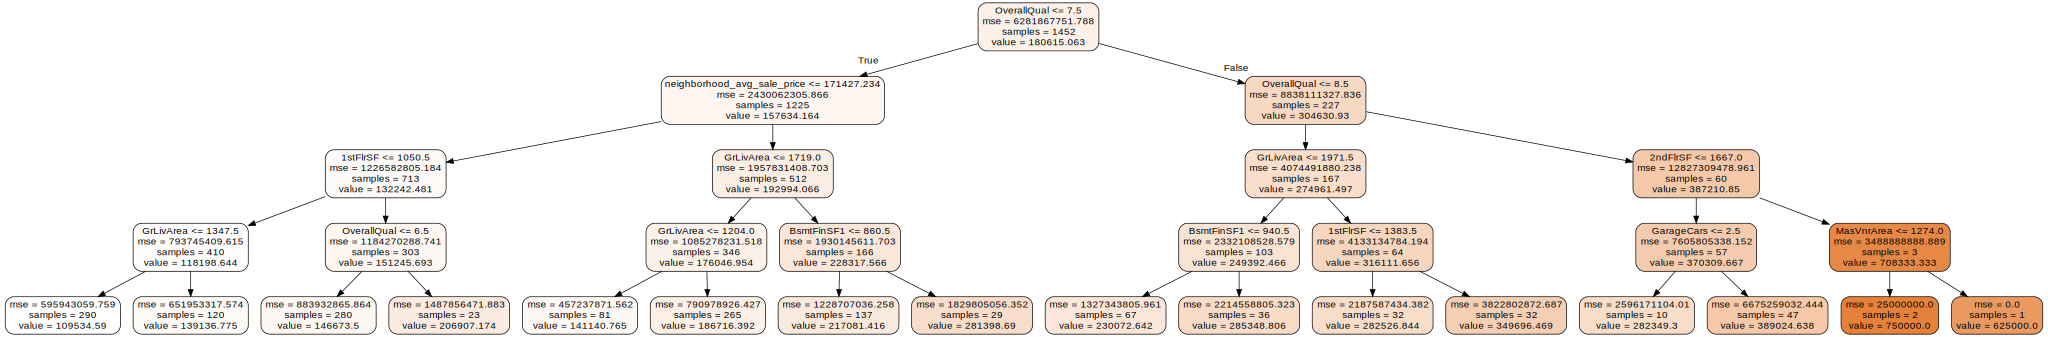

In [87]:
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook

features = ['LotArea', 'Area x Qual', 'neighborhood_qual', 'neighborhood_avg_sale_price']
df_x = df[features]
df_x = df.select_dtypes('number').drop(columns=['SalePrice', 'ln_price'])
df_y = df['SalePrice']
tree = DecisionTreeRegressor(max_depth = 4)#, max_features = 5)
tree.fit(df_x, df_y)

print(len(tree.feature_importances_))
print("RMSE:", np.sqrt(mean_squared_error(df_y, tree.predict(df_x))))
display(viztree(tree, df_x.columns))


## Part 2 / Stretch: "Play Tennis" Classification

We'll reproduce the "Play Tennis" example from Ross Quinlan's 1986 paper, [Induction of Decison Trees](https://link.springer.com/content/pdf/10.1007%2FBF00116251.pdf).

[According to Wikipedia](https://en.wikipedia.org/wiki/Ross_Quinlan), "John Ross Quinlan is a computer science researcher in data mining and decision theory. He has contributed extensively to the development of decision tree algorithms, including inventing the canonical C4.5 and ID3 algorithms."

#### "Table 1 shows a small training set"

In [6]:
import pandas as pd

columns = 'No. Outlook Temperature Humidity Windy PlayTennis'.split()

raw = """1 sunny hot high false N
2 sunny hot high true N
3 overcast hot high false P
4 rain mild high false P
5 rain cool normal false P
6 rain cool normal true N
7 overcast cool normal true P
8 sunny mild high false N
9 sunny cool normal false P
10 rain mild normal false P
11 sunny mild normal true P
12 overcast mild high true P
13 overcast hot normal false P
14 rain mild high true N"""

data = [row.split() for row in raw.split('\n')]
tennis = pd.DataFrame(data=data, columns=columns).set_index('No.')
tennis['PlayTennis'] = (tennis['PlayTennis'] == 'P').astype(int)

tennis

,Outlook,Temperature,Humidity,Windy,PlayTennis
No.,,,,,
1,sunny,hot,high,false,0
2,sunny,hot,high,true,0
3,overcast,hot,high,false,1
4,rain,mild,high,false,1
5,rain,cool,normal,false,1
6,rain,cool,normal,true,0
7,overcast,cool,normal,true,1
8,sunny,mild,high,false,0
9,sunny,cool,normal,false,1


#### "A decision tree that correctly classifies each object in the training set is given in Figure 2."

<img src="https://i.imgur.com/RD7d0u0.png" height="300">

In this dataset, the tennis player decided to play on 64% of the days, and decided not to on 36% of the days.

In [7]:
tennis['PlayTennis'].value_counts(normalize=True) * 100

1    64.285714
0    35.714286
Name: PlayTennis, dtype: float64

The tennis player played on 100% of the overcast days, 40% of the sunny days, and 60% of the  rainy days

In [8]:
tennis.groupby('Outlook')['PlayTennis'].mean() * 100

Outlook
overcast    100.0
rain         60.0
sunny        40.0
Name: PlayTennis, dtype: float64

On sunny days, the tennis player's decision depends on the humidity. (The Outlook and Humidity features interact.)

In [9]:
sunny = tennis[tennis['Outlook']=='sunny']
sunny.groupby('Humidity')['PlayTennis'].mean() * 100

Humidity
high        0
normal    100
Name: PlayTennis, dtype: int64

On rainy days, the tennis player's decision depends on the wind. (The Outlook and Windy features interact.)

In [10]:
rainy = tennis[tennis['Outlook']=='rain']
rainy.groupby('Windy')['PlayTennis'].mean() * 100

Windy
false    100
true       0
Name: PlayTennis, dtype: int64

#### Before modeling, we will ["encode" categorical variables, using pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html?highlight=get_dummies#computing-indicator-dummy-variables)

In [11]:
y = tennis['PlayTennis']
X = pd.get_dummies(tennis.drop(columns='PlayTennis'))
X

,Outlook_overcast,Outlook_rain,Outlook_sunny,Temperature_cool,Temperature_hot,Temperature_mild,Humidity_high,Humidity_normal,Windy_false,Windy_true
No.,,,,,,,,,,
1,0,0,1,0,1,0,1,0,1,0
2,0,0,1,0,1,0,1,0,0,1
3,1,0,0,0,1,0,1,0,1,0
4,0,1,0,0,0,1,1,0,1,0
5,0,1,0,1,0,0,0,1,1,0
6,0,1,0,1,0,0,0,1,0,1
7,1,0,0,1,0,0,0,1,0,1
8,0,0,1,0,0,1,1,0,1,0
9,0,0,1,1,0,0,0,1,1,0


## Train a Decision Tree Classifier
Get a score of 100% (accuracy)

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

## Compare to Logistic Regression
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

## Visualize the tree
https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html